In [1]:
import numpy as np
import decimal
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cityblock
import glob
import statistics as st

from apollon.som.som import IncrementalMap
from apollon.som.utilities import best_match

## Prepare features

In [2]:
features = {1:'Spectral Centroid',
           2 : 'Spectral Spread',
           3 :'Spectral Flux',
           4 : 'Roughness',
           5 : 'Sharpness',
           6 : 'SPL',
           7 : 'Correlation Dimension'}

#Define a feature set from features, {count (1,2,3...), feature number in features}
nfeatures = {1 :6}    #6: SPL
             #2: 5,   #5: Sharpness
             #3: 3}   #...
             #4: 4,
             #5: 5,
             #6: 1}
#.csv Files of extracted features, see Example Notebook 'TimbreTrack_Extract_Features'
files = list(glob.glob("FilePath/*.csv"))
numfiles = len(files)
numfeatures = len(nfeatures)
lal1 = np.empty((numfiles, numfeatures))
for j, f in enumerate(files):
    la = pd.read_csv(f, index_col=0)
    for i in nfeatures:
        lal1[j][i-1] = la[features[nfeatures[i]]].std()      #calculate standard deviation of feature over time
        #lal1[j][i-1] = la[features[nfeatures[i]]].mean()#calculate mean of features over time

In [3]:
#In case of multiple file sets in different file folders:
files = list(glob.glob("AnotherFilePath/*.csv"))
numfiles = len(files)
numfeatures = len(nfeatures)
lbl1 = np.empty((numfiles, numfeatures))
for j, f in enumerate(files):
    la = pd.read_csv(f, index_col=0)
    for i in nfeatures:
        lbl1[j][i-1] = la[features[nfeatures[i]]].std()
        #lbl1[j][i-1] = la[features[nfeatures[i]]].mean()

In [4]:
#Build training vector in case of two sets
train_X = np.concatenate((lal1,lbl1))
features=numfeatures

In [22]:
#Example target for two sets
target = [('a', i+1) for i in range(0,len(lal1))] + [('b', i+1) for i in range(0,len(lbl1))]

## Fit SOM

In [23]:
dx = int(np.sqrt(train_X.shape[0]))+10
dw = train_X.shape[1]
som = IncrementalMap((dx, dx, dw), n_iter=500, eta=0.05, nhr=25)

In [24]:
som.fit(train_X)

## Results

In [25]:
um = som.umatrix()
bmu, err = best_match(som.weights, train_X, som.metric)
px, py = np.unravel_index(bmu, som.shape)

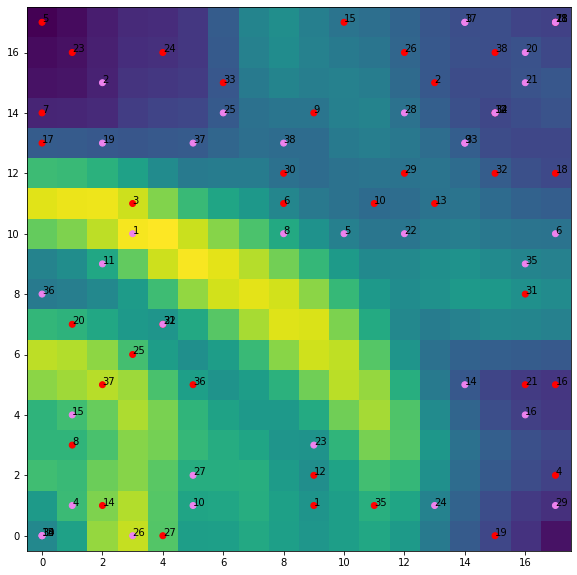

In [26]:
#Plot SOM and matched sound files
color_map = {'a': 'red', 'b': 'violet'}

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(um, aspect='equal', origin='lower')

ax.scatter(py, px, c=[color_map[t[0]] for t in target])

for t, (y, x) in zip(target, zip(px, py)):
    ax.text(x, y, t[1])

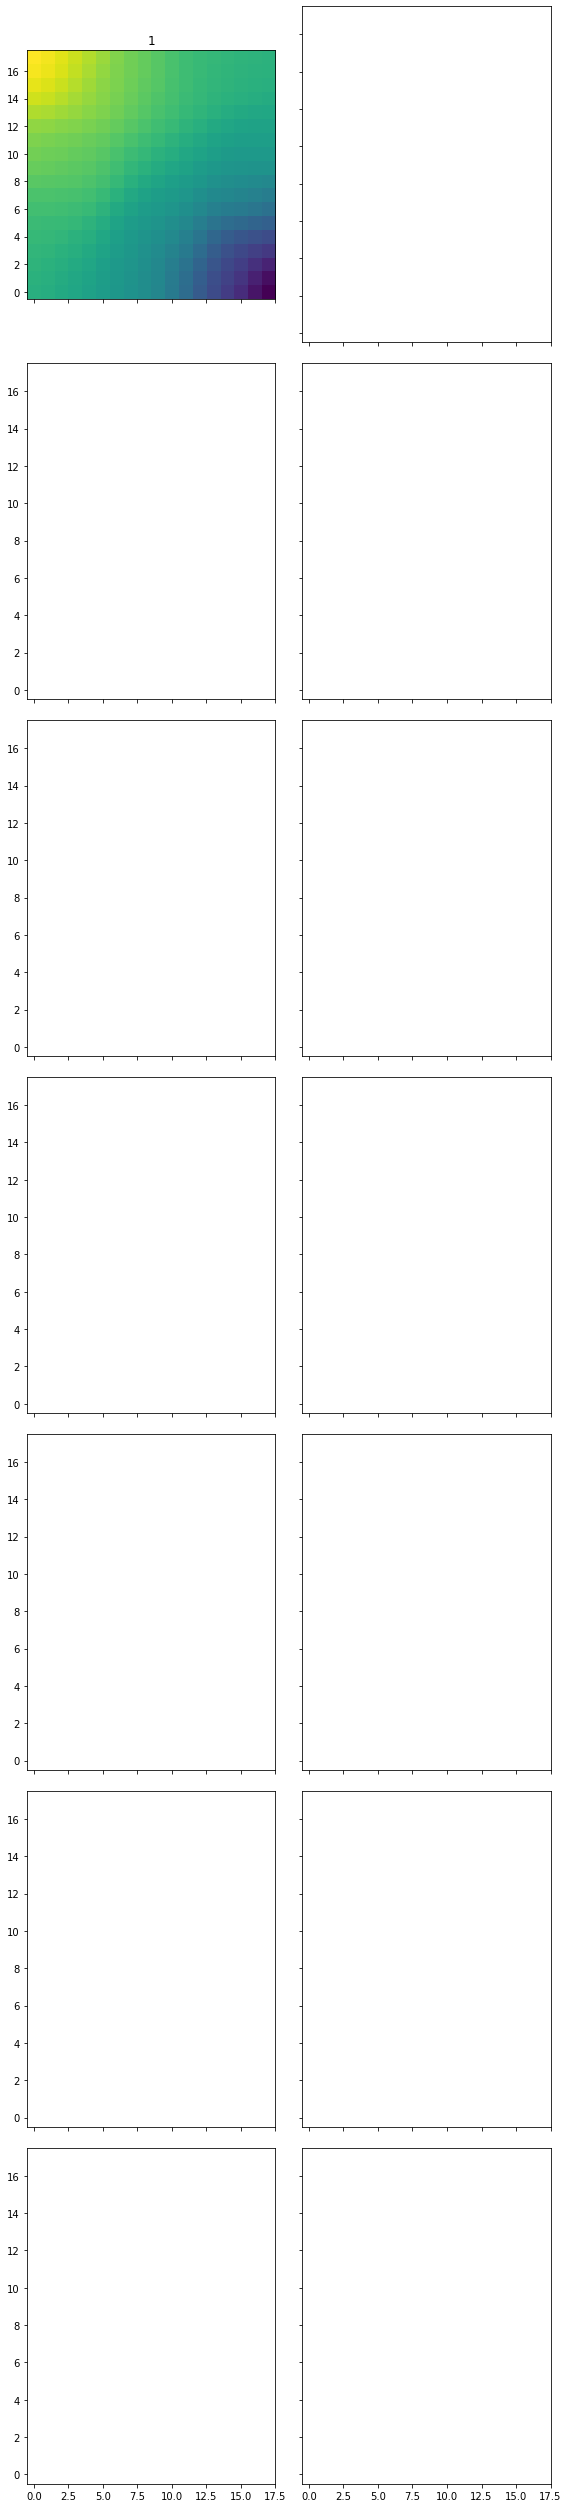

In [18]:
#Plot component plate, each subplot is a feature selected above
fig, (axs) = plt.subplots(7, 2, figsize=(8, 35), sharex=True, sharey=True)
fig.tight_layout()
for i, (fn, ax) in enumerate(zip(nfeatures, axs.flatten())):
    ax.set_title(fn)
    ax.imshow(som.weights[:, i].reshape(som.shape), origin='lower', aspect='equal')